# Technical Data Analysis and Cleaning

This notebook loads technical capacity and generation data, performs basic statistics, and standardizes generation data column names for improved readability and consistency. The workflow includes:

- Reading input files
- Aggregating capacity by zone, tech, and status
- Cleaning column names in generation data
- Ensuring no data loss during cleaning

In [15]:
import os
import pandas as pd

## 1. Load Data

In [16]:
folder_input = 'data_capp'
file = 'EPM'
generation_file = os.path.join("../..", "epm", "input", folder_input, "supply", "pGenDataInput.csv")
if not os.path.exists(generation_file):
    raise FileNotFoundError(f"Generation file not found: {generation_file}")
# Load generation data
generation_data = pd.read_csv(generation_file, encoding='utf-8', low_memory=False)

# Keep raw data for later use
raw_generation_data = generation_data.copy()

# Check the first few rows of the generation data
display(generation_data.head())

,gen,zone,tech,fuel,Status,StYr,RetrYr,Capacity,DescreteCap,fuel2,...,MinLimitShare,HeatRate,RampUpRate,RampDnRate,OverLoadFactor,ResLimShare,Capex,FOMperMW,VOM,ReserveCost
0,AH_Cambambe_C1,Angola,ReservoirHydro,Water,1.0,1962.0,2060.0,260,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AH_Cambambe_C2,Angola,ReservoirHydro,Water,1.0,2016.0,2060.0,700,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AH_Capanda,Angola,ReservoirHydro,Water,1.0,2004.0,2060.0,520,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AH_Lauca,Angola,ReservoirHydro,Water,1.0,2017.0,2060.0,2070,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ah_Lauca_ECO,Angola,ReservoirHydro,Water,1.0,2023.0,2060.0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
folder_output = 'output'
if not os.path.exists(folder_output):
    os.makedirs(folder_output)

## 2. Clean "gen" characters in Generation Data
Generation column names vary across data sources. We'll clean and standardize them using the following rules:

- Remove parentheses
- Replace "solar" with "PV"
- Replace spaces and dots with underscores
- Capitalize only the first letter
- Remove trailing underscores
- If duplicate names appear after cleaning, append "_1", "_2", etc.

In [18]:
import re

replacements_adhoc = {
    'ago': 'Angola',
    'drc': 'DRC',
    'drcsouth': 'DRC_South',
    'bur': 'Burundi'
}


def standardize_name(value):
    if pd.isnull(value):
        return value

    value = str(value).lower().strip()  # Normalize case and remove leading/trailing spaces

    # Remove anything inside parentheses
    value = re.sub(r"\(.*?\)", "", value)

    # Replace common variants and aliases (case-insensitive handled by lower())
    replacements = {
        "solar": "PV",
        "pv": "PV",
        "wind": "Wind",
        "wind onshore": "OnshoreWind",
        "onshorewind": "OnshoreWind",
        "wind offshore": "OffshoreWind",
        "offshorewind": "OffshoreWind",
        "hydropower": "Hydro",
        "hydroelectric": "Hydro",
        "hy": "Hydro",
        "nat gas": "Gas",
        "natural gas": "Gas",
        "bioenergy": "Biomass",
        "bess": "BESS"
    }

    # Add adhoc replacements
    replacements.update(replacements_adhoc)

    for key, val in replacements.items():
        value = value.replace(key, val)

    # Replace spaces and dots with underscores
    value = value.replace(".", "_").replace(" ", "_")

    # Remove all characters except letters, numbers, and underscores
    # This line removes characters like &, /, -, etc.
    value = re.sub(r"[^a-zA-Z0-9_]", "", value)  # <-- Removes all non-alphanumeric characters except underscores

    # Remove multiple or trailing underscores
    value = re.sub(r"_+", "_", value)  # Replace repeated underscores with a single underscore
    value = value.strip("_")           # Remove underscores at start or end

    # Capitalize only the first letter
    value = value.capitalize()

    return value

# Clean column names in generation data
generation_data["gen_cleaned"] = generation_data["gen"].apply(standardize_name)
# Add the gen_cleaned just after the original gen column
generation_data.insert(generation_data.columns.get_loc("gen") + 1, "gen_cleaned", generation_data.pop("gen_cleaned"))

# Replace original columns with cleaned values
generation_data["gen"] = generation_data["gen_cleaned"]
generation_data.drop(columns=["gen_cleaned"], inplace=True)
generation_data = generation_data[generation_data.columns]

In [19]:
from collections import defaultdict

def parse_duplicates(df):
    """ Parses duplicates in the 'gen_cleaned' column of the DataFrame.
    If duplicates are found, appends a suffix to make them unique.
    """

    # Number of unique generation names before cleaning
    unique_gen_count_before = df["gen"].nunique()

    # Check for duplicates in the cleaned generation names
    duplicates = df["gen"].duplicated(keep=False)
    # Display duplicates
    if duplicates.any():
        print("Duplicate generation names found:")
        print(df[duplicates][["gen"]].drop_duplicates())

        # Step 2: Create a copy to modify
        gen_cleaned_series = df["gen"].copy()

        # Step 3: Count occurrences and rename with suffixes
        name_counters = defaultdict(int)
        new_names = []

        for name in gen_cleaned_series:
            name_counters[name] += 1
            count = name_counters[name]
            if count == 1:
                new_names.append(name)
            else:
                new_names.append(f"{name}_{count-1}")

        # Step 4: Assign new names back
        df["gen"] = new_names
    else:
        print("No duplicate generation names found.")

    # Number of unique generation names after cleaning
    unique_gen_count_after = df["gen"].nunique()
    print(f"Unique generation names before cleaning: {unique_gen_count_before}")
    print(f"Unique generation names after cleaning: {unique_gen_count_after}")

    return df

# Apply the duplicate parsing function
generation_data = parse_duplicates(generation_data)

Duplicate generation names found:
            gen
49   Ruvyironza
73      Bambari
168     Chollet
201        Bata
Unique generation names before cleaning: 382
Unique generation names after cleaning: 386


## 3. Format Capacity Data

In [20]:
def clean_capacity(value):
    if pd.isnull(value):
        return None

    value = str(value).strip()

    # Replace comma as decimal separator (e.g., European format) → assume comma means decimal
    if value.count(",") > 0 and value.count(".") == 0:
        value = value.replace(",", ".")

    # Remove thousand separators (e.g., "1,000.5" or "1.000,5")
    value = value.replace(",", "").replace(" ", "")

    try:
        return float(value)
    except ValueError:
        return None  # or np.nan if using numpy

generation_data["Capacity"] = generation_data["Capacity"].apply(clean_capacity)

## 4. Clean tech and fuels

In [21]:
def clean_generation_fuel_tech(df):
    """
    Cleans 'fuel' and 'tech' columns in a generation DataFrame.
    Applies normalization and standardized naming conventions.
    Overwrites 'fuel' and 'tech' columns with cleaned values.
    """
    df_cleaned = df.copy()

    # Normalize values to lowercase and strip whitespace
    df_cleaned["fuel_clean"] = df_cleaned["fuel"].astype(str).str.strip().str.lower()
    df_cleaned["tech_clean"] = df_cleaned["tech"].astype(str).str.strip().str.lower()

    # Rule 1: Oil → Diesel
    df_cleaned.loc[df_cleaned["fuel_clean"] == "oil", "fuel_clean"] = "diesel"

    # Rule 2: Diesel or HFO → OCGT
    df_cleaned.loc[
        df_cleaned["fuel_clean"].isin(["diesel", "hfo"]),
        "tech_clean"
    ] = "ocgt"

    # Rule 3: Coal or Lignite → ST
    df_cleaned.loc[
        df_cleaned["fuel_clean"].isin(["coal", "lignite"]),
        "tech_clean"
    ] = "st"

    # Rule 4: Wind → OnshoreWind or OffshoreWind (default: OnshoreWind)
    is_wind = df_cleaned["fuel_clean"] == "wind"
    tech_vals = df_cleaned["tech_clean"]
    df_cleaned.loc[
        is_wind & tech_vals.str.contains("offshore", na=False),
        "tech_clean"
    ] = "offshorewind"
    df_cleaned.loc[
        is_wind & ~tech_vals.str.contains("offshore", na=False),
        "tech_clean"
    ] = "onshorewind"


    # Rule 5: Biomass or Waste → Biomass plant
    df_cleaned.loc[
        df_cleaned["fuel_clean"].isin(["biomass", "waste", "peat"]),
        "tech_clean"
    ] = "biomassplant"


    # Rule 6: Water → ROR or ReservoirHydro (default: ReservoirHydro)
    is_water = df_cleaned["fuel_clean"] == "water"
    df_cleaned.loc[
        is_water & tech_vals.str.contains("ror", na=False),
        "tech_clean"
    ] = "ror"
    df_cleaned.loc[
        is_water & ~tech_vals.str.contains("ror", na=False),
        "tech_clean"
    ] = "reservoirhydro"

    # Rule 7: Gas → OCGT or CCGT (default: OCGT)
    is_gas = df_cleaned["fuel_clean"] == "gas"
    df_cleaned.loc[
        is_gas & tech_vals.str.contains("ccgt", na=False),
        "tech_clean"
    ] = "ccgt"
    df_cleaned.loc[
        is_gas & ~tech_vals.str.contains("ccgt", na=False),
        "tech_clean"
    ] = "ocgt"

    # Rule 8: Tech PV → Fuel Solar
    df_cleaned.loc[
        df_cleaned["tech_clean"] == "pv",
        "fuel_clean"
    ] = "solar"

    # Final formatting: replace internal values with official names (title case or acronyms)
    tech_map = {
        "pv": "PV",
        "ocgt": "OCGT",
        "ccgt": "CCGT",
        "st": "ST",
        "onshorewind": "OnshoreWind",
        "offshorewind": "OffshoreWind",
        "ror": "ROR",
        "reservoirhydro": "ReservoirHydro",
        "biomassplant": "BiomassPlant",
        "cspplant": "CSPPlant",
        "storage": "Storage"
    }

    fuel_map = {
        "diesel": "Diesel",
        "hfo": "HFO",
        "coal": "Coal",
        "lignite": "Lignite",
        "gas": "Gas",
        "wind": "Wind",
        "biomass": "Biomass",
        "waste": "Biomass",
        "peat": "Biomass",
        "water": "Water",
        "csp": "CSP",
        "pv": "Solar",
        "hy": "Hydro",
        "solar": "Solar",
        "battery": "Battery",
    }


    #.fillna(df_cleaned["tech_clean"].str.capitalize())
    df_cleaned["tech_clean"] = df_cleaned["tech_clean"].map(tech_map)
    df_cleaned["fuel_clean"] = df_cleaned["fuel_clean"].map(fuel_map)


    # Replace original columns with cleaned values
    df_cleaned["fuel"] = df_cleaned["fuel_clean"]
    df_cleaned["tech"] = df_cleaned["tech_clean"]

    # Drop intermediate columns
    df_cleaned.drop(columns=["fuel_clean", "tech_clean"], inplace=True)

    # Reorder columns to match the original
    df_cleaned = df_cleaned[df.columns]

    return df_cleaned

generation_data = clean_generation_fuel_tech(generation_data)
generation_data.to_csv(os.path.join(folder_output, 'pGenDataInput_0.csv'), index=False, encoding='utf-8-sig')

In [22]:
# Verify

# Raw URL of the CSV
tech_data = "https://raw.githubusercontent.com/ESMAP-World-Bank-Group/EPM/main/docs/dwld/pGenDataInputDefault_CCDR.csv"

# Load tech data
tech_data = pd.read_csv(tech_data, encoding='utf-8', low_memory=False)
tech_data = tech_data[["tech", "fuel"]]

# Check if all tech and fuel combinations in generation data are present in tech data
missing_tech = generation_data[~generation_data[["tech", "fuel"]].apply(tuple, 1).isin(tech_data.apply(tuple, 1))]
if not missing_tech.empty:
    print("Missing tech and fuel combinations in generation data:")
    print(missing_tech[["tech", "fuel"]].drop_duplicates())
else:
    print("All tech and fuel combinations in generation data are present in tech data.")


Missing tech and fuel combinations in generation data:
        tech fuel
28  CSPPlant  CSP


## 5. Complete Status Column

- By default if the status column is not present, we assume all generation is candidate (Status == 3).
- Power plants with a capacity of 0 are considered "deleted" (Status == 0), and should be removed from the dataset.
- Ensure that the Status column is present, without empty values and values are {1, 2, 3}.

In [23]:
def ensure_status_and_unique_gen(df):
    """
    Ensures the 'Status' column exists and contains only values {1, 2, 3}.
    - If missing, assigns Status = 3 (candidate) to all rows.
    - Fills any empty or invalid entries with 3.
    """
    df_cleaned = df.copy()

    # 1. Ensure Status column exists
    if "Status" not in df_cleaned.columns:
        df_cleaned["Status"] = 3  # Assume all are candidates

    # 2. Normalize and fill invalid or missing values
    df_cleaned["Status"] = pd.to_numeric(df_cleaned["Status"], errors="coerce").fillna(3).astype(int)
    df_cleaned["Status"] = df_cleaned["Status"].clip(lower=1, upper=3)
    print(f"Status column unique values: {df_cleaned['Status'].unique()}")

    return df_cleaned

generation_data = ensure_status_and_unique_gen(generation_data)

Status column unique values: [1 2 3]


## 6. Simplified Generation Data

Simplified generation data for easier analysis:
- If same zone, tech, fuel, and Status, StYr, RetrYr. Generate new Aggregated_{tech}_{zone} with the sum the capacity, and remove the original rows.
- Only focus on Capacity > 1% of total capacity in the country. For 1 GW country, this means only keeping plants with capacity > 10 MW.
- For PV, Wind tech that is committed, Status == 2. Rename the name to "{tech}_{zone}_{StYr}" and keep only the committed plants.
- If Status == 2, but no date, put StYr = 2030
- Ensure that all countries have New_pv_{zone}*, New_bess_{zone}*, New_hfo_{zone}* StYr in 2030, if not print what's miising

In [24]:
def fill_missing_years(df):
    df["StYr"] = pd.to_numeric(df["StYr"], errors="coerce").astype("Int64")
    df.loc[(df["Status"] == 3) & (df["StYr"].isna()), "StYr"] = 2030
    df.loc[(df["Status"] == 2) & (df["StYr"].isna()), "StYr"] = 2030
    df.loc[(df["Status"] == 1) & (df["StYr"].isna()), "StYr"] = 2025

    return df

def set_retr_year_default(df, default_year=2050):
    """
    Fills missing or invalid 'RetrYr' values with a default (2050).
    """
    df = df.copy()
    df["RetrYr"] = pd.to_numeric(df["RetrYr"], errors="coerce")
    df["RetrYr"] = df["RetrYr"].fillna(default_year).astype(int)

    # If RetrYr > default_year, set it to default_year
    df.loc[df["RetrYr"] > default_year, "RetrYr"] = default_year

    return df

def remove_rtr_year_removed(df, current_year=2025):
    """
    Removes rows where 'RetrYr' is less than or equal to the current year.
    """
    df = df.copy()
    return df[df["RetrYr"] > current_year].copy()



def remove_zero_capacity(df):
    df["Capacity"] = pd.to_numeric(df["Capacity"], errors="coerce").fillna(0)
    return df[df["Capacity"] > 0].copy()



def rename_committed(df):
    committed_mask = (df["Status"] == 2) & (df["tech"].isin(["PV", "OnshoreWind", "OffshoreWind"]))
    df.loc[committed_mask, "gen"] = df.loc[committed_mask].apply(
        lambda row: f"{row['tech']}_{row['zone']}_{int(row['StYr'])}", axis=1
    )
    return df



def report_missing_candidates(df):
    required_techs = ["pv", "bess", "hfo"]
    missing = []

    for zone in df["zone"].unique():
        zone_2030 = df[(df["zone"] == zone) & (df["StYr"] == 2030)]["gen"].str.lower()
        for tech in required_techs:
            expected = f"Candidate_{tech}".lower()
            if not any(name.startswith(expected) for name in zone_2030):
                missing.append((zone, f"Candidate_{tech}_{zone}"))

    if missing:
        print("Missing 2030 candidate projects:")
        for zone, name in missing:
            print(f"- {zone}: {name}")

    else:
        print("All countries have required 2030 candidate projects.")

    return missing


def simplify_generation_data(df):
    print("Simplifying generation data...")
    print(f"Initial rows: {len(df)}")

    df = df.copy()
    required_cols = ["zone", "tech", "fuel", "Status", "StYr", "RetrYr", "Capacity", "gen"]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    df = fill_missing_years(df)

    df = set_retr_year_default(df, default_year=2050)
    df = remove_rtr_year_removed(df, current_year=2025)

    df = remove_zero_capacity(df)
    print(f"Rows after filling missing years and removing zero capacity: {len(df)}")


    df = rename_committed(df)

    report_missing_candidates(df)
    df = parse_duplicates(df)

    print("Generation data simplified successfully.")
    print(f"Total rows after simplification: {len(df)}")
    return df.reset_index(drop=True)

generation_data.to_csv('test.csv', index=False, encoding='utf-8-sig')

generation_data_simple = simplify_generation_data(generation_data)
generation_data_simple.to_csv(os.path.join(folder_output, 'pGenDataInput_1.csv'), index=False, encoding='utf-8-sig')

Simplifying generation data...
Initial rows: 386
Rows after filling missing years and removing zero capacity: 378
Missing 2030 candidate projects:
- Angola: Candidate_hfo_Angola
- Burundi: Candidate_hfo_Burundi
- CAF: Candidate_hfo_CAF
- Cameroon: Candidate_hfo_Cameroon
- Congo: Candidate_hfo_Congo
- EquatorialGuinea: Candidate_hfo_EquatorialGuinea
- Gabon: Candidate_hfo_Gabon
- DRC: Candidate_pv_DRC
- DRC: Candidate_bess_DRC
- DRC: Candidate_hfo_DRC
- DRC_South: Candidate_pv_DRC_South
- DRC_South: Candidate_bess_DRC_South
- DRC_South: Candidate_hfo_DRC_South
No duplicate generation names found.
Unique generation names before cleaning: 378
Unique generation names after cleaning: 378
Generation data simplified successfully.
Total rows after simplification: 378


In [25]:
def aggregate_generators(df):
    """
    Aggregates generators by:
    - (zone, tech, fuel, RetrYr, Status=1) → Existing_tech_zone_RetrYr
    - (zone, tech, fuel, StYr, Status=2) → Committed_tech_zone_StYr
    - (zone, tech, fuel, StYr, Status=3) → Candidate_tech_zone_StYr

    Keeps first value of other fields, sums capacity.
    Only renames if aggregation occurs.
    Preserves gen name and order. Validates capacity.
    """
    df = df.copy()
    df["Capacity"] = pd.to_numeric(df["Capacity"], errors="coerce").fillna(0)
    df["__order"] = range(len(df))  # To preserve original order

    total_capacity_before = df["Capacity"].sum()

    # Separate by status
    df1 = df[df["Status"] == 1].copy()
    df2 = df[df["Status"] == 2].copy()
    df3 = df[df["Status"] == 3].copy()

    def aggregate_group(data, year_col, status_label):
        group_cols = ["zone", "tech", "fuel", year_col, "Status"]
        all_cols = data.columns.tolist()
        keep_cols = [col for col in all_cols if col not in group_cols + ["Capacity", "gen", "__order"]]

        aggregated_rows = []

        # Do not aggregate if fuel == 'Water'
        water_mask = data["fuel"] == "Water"
        non_water = data[~water_mask]
        water = data[water_mask]


        for keys, group in non_water.groupby(group_cols):
            if len(group) == 1:
                aggregated_rows.append(group.iloc[0])
            else:
                agg_row = group.iloc[0].copy()
                agg_row["Capacity"] = group["Capacity"].sum()
                for col in keep_cols:
                    agg_row[col] = group[col].iloc[0]
                year_val = keys[3]
                agg_row["gen"] = f"{status_label}_{keys[1]}_{keys[2]}_{keys[0]}_{year_val}"
                aggregated_rows.append(agg_row)

        # Handle water separately and do not aggregate
        if not water.empty:
            for _, row in water.iterrows():
                aggregated_rows.append(row)



        return pd.DataFrame(aggregated_rows)

    aggregated_1 = aggregate_group(df1, "RetrYr", "Existing")
    aggregated_2 = aggregate_group(df2, "StYr", "Committed")
    aggregated_3 = aggregate_group(df3, "StYr", "Candidate")

    result_df = pd.concat([aggregated_1, aggregated_2, aggregated_3], ignore_index=True)

    # Sort back to original order
    result_df = result_df.sort_values("__order").drop(columns="__order").reset_index(drop=True)

    # Validate total capacity
    total_capacity_after = result_df["Capacity"].sum()
    if not abs(total_capacity_before - total_capacity_after) < 1e-6:
        if "zone" in df.columns and "tech" in df.columns:
            cap_before = df.groupby(["zone", "tech", "fuel"])["Capacity"].sum()
            cap_after = result_df.groupby(["zone", "tech", "fuel"])["Capacity"].sum()

            capacity_diff = (cap_before - cap_after).round(6)
            capacity_diff = capacity_diff[capacity_diff != 0]

            if not capacity_diff.empty:
                print("Capacity differences by zone and tech:")
                print(capacity_diff)
            else:
                print("Capacity mismatch detected but not attributable by zone-tech.")
                print("Total capacity before aggregation:", total_capacity_before)
                print("Total capacity after aggregation:", total_capacity_after)
                result_df.to_csv("pGenDataInput_error.csv", index=False, encoding="utf-8-sig")

        result_df.to_csv("pGenDataInput_simplified_aggregated.csv", index=False, encoding="utf-8-sig")
        raise ValueError("Total capacity mismatch after aggregation!")

    return result_df

generation_data_aggr = aggregate_generators(generation_data_simple)
generation_data_aggr.to_csv(os.path.join(folder_output, 'pGenDataInput_2.csv'), index=False, encoding='utf-8-sig')

In [26]:
def filter_small_units(df):
    capacity_by_zone = df[df['Status'] == 1].groupby("zone")["Capacity"].sum()
    thresholds = (capacity_by_zone * 0.01).to_dict()

    df["__small"] = df.apply(
        lambda row: row["Capacity"] <= thresholds.get(row["zone"], 0),
        axis=1
    )

    print(f"Total rows before filtering small units: {len(df)}")
    print(f"Total capacity filtered out: {df[df['__small']]['Capacity'].sum()} MW")
    print(f'Total capacity be country filtered out: {df[df["__small"]].groupby("zone")["Capacity"].sum()} MW')

    df = df[~df["__small"]].copy()
    df.drop(columns=["__small"], inplace=True)

    print(f"Total rows after filtering small units: {len(df)}")
    return df

generation_data_aggr = filter_small_units(generation_data_aggr)

# Sort by zone, tech, fuel, Status, StYr, Capacity
generation_data_aggr = generation_data_aggr.sort_values(
    by=["zone", "tech", "fuel", "Status", "StYr", "Capacity"],
    ascending=[True, True, True, True, True, False]
).reset_index(drop=True)

generation_data_aggr.to_csv(os.path.join(folder_output, 'pGenDataInput_3.csv'), index=False, encoding='utf-8-sig')


Total rows before filtering small units: 262
Total capacity filtered out: 161.465 MW
Total capacity be country filtered out: zone
Angola              121.000
Burundi               3.700
CAF                   0.850
Cameroon              1.400
Congo                 6.565
DRC                  11.000
EquatorialGuinea      6.950
Gabon                10.000
Name: Capacity, dtype: float64 MW
Total rows after filtering small units: 241


## Fill other columns

- BuildLimitperYear should be the Capacity except for PV, Wind, BESS where it should be 1GW/year (optimistic value).
- RetrYr equal 2050 if no information.

In [31]:

def set_build_limit_per_year(df, pv_limit=1000, wind_limit=1000, bess_limit=1000):
    """
    Sets 'BuildLimitperYear':
    - Status == 3 (candidate): tech-specific max limit
    - Status == 2 (committed): equals Capacity
    """
    df = df.copy()
    df["Capacity"] = pd.to_numeric(df["Capacity"], errors="coerce").fillna(0)

    # Initialize column
    df["BuildLimitperYear"] = None

    # Candidates: tech-specific limits
    mask_candidate = df["Status"] == 3
    df.loc[mask_candidate, "BuildLimitperYear"] = df.loc[mask_candidate, "tech"].map({
        "PV": pv_limit,
        "OnshoreWind": wind_limit,
        "OffshoreWind": wind_limit,
        "BESS": bess_limit,
    }).fillna(df["Capacity"])  # default fallback

    # Committed: use actual Capacity
    df.loc[df["Status"] == 2, "BuildLimitperYear"] = df.loc[df["Status"] == 2, "Capacity"]

    return df


generation_data_aggr = filter_small_units(generation_data_aggr)
generation_data_aggr = set_build_limit_per_year(generation_data_aggr)

# Sort by zone, Status, tech, fuel, Capacity
generation_data_aggr = generation_data_aggr.sort_values(
    by=["zone", "Status", "tech", "fuel", "Capacity"],
    ascending=[True, True, True, True, False]
).reset_index(drop=True)

generation_data_aggr.to_csv(os.path.join(folder_output, 'pGenDataInput_final.csv'), index=False, encoding='utf-8-sig')


Total rows before filtering small units: 241
Total capacity filtered out: 0.0 MW
Total capacity be country filtered out: Series([], Name: Capacity, dtype: float64) MW
Total rows after filtering small units: 241


## 7. Display Existing and Committed Generation Data

### Display existing generation data

In [28]:
color_tech_fuel = {
    'PV_Solar': 'yellow',
    'OnshoreWind_Wind': 'green',
    'OffshoreWind_Wind': 'blue',
    'OCGT_Gas': 'orange',
    'CCGT_Gas': 'red',
    'ST_Coal': 'brown',
    'BiomassPlant_Biomass': 'purple',
    'ROR_Water': 'cyan',
    'ReservoirHydro_Water': 'lightblue',
    'CSPPlant_Solar': 'goldenrod'
}

tech_fuel,BiomassPlant_Biomass,CCGT_Gas,OCGT_Diesel,OCGT_Gas,OCGT_HFO,PV_Solar,ROR_Water,ReservoirHydro_Water
zone,,,,,,,,
Angola,0.0,750.0,741.00,105.00,0.0,276.0,0.00,3686.0
Burundi,0.0,0.0,34.00,0.00,0.0,8.0,35.00,33.0
CAF,0.0,0.0,39.74,0.00,0.0,0.0,28.55,0.0
Cameroon,50.0,0.0,140.36,266.70,186.0,70.0,230.00,0.0
Congo,0.0,0.0,0.00,534.00,0.0,0.0,0.00,195.0
DRC,0.0,0.0,0.00,0.00,150.8,0.0,0.00,2227.0
DRC_South,0.0,0.0,0.00,0.00,0.0,0.0,0.00,729.0
EquatorialGuinea,0.0,0.0,201.14,0.00,24.8,0.0,0.00,120.0
Gabon,0.0,0.0,57.15,271.33,0.0,0.0,0.00,285.1


<Axes: xlabel='zone'>

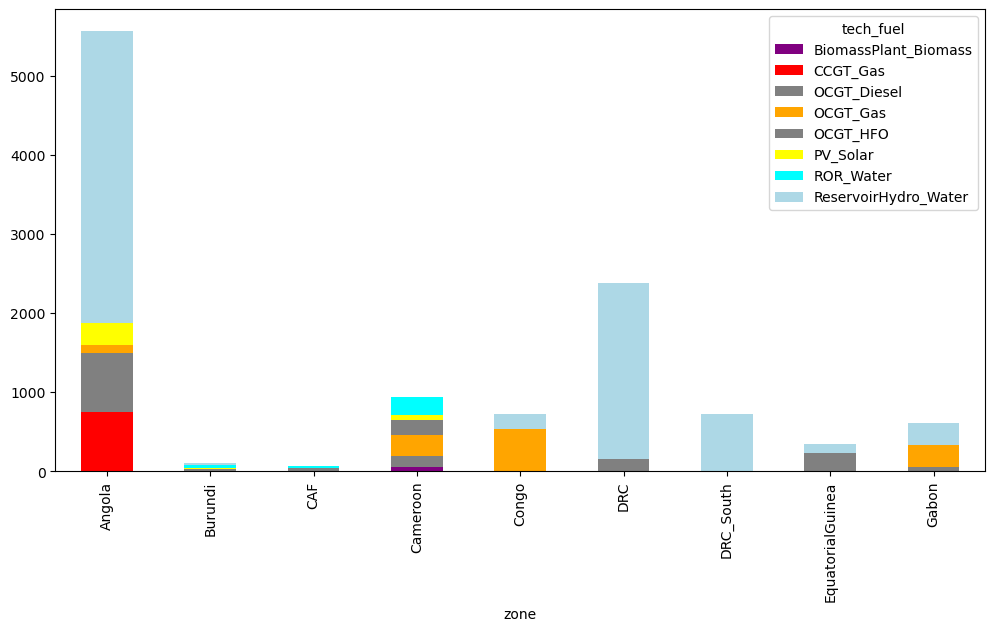

In [29]:
temp = generation_data_aggr.groupby(['zone', 'tech', 'fuel', 'Status'])['Capacity'].sum().reset_index()
# Sort temp by zone and tech and status
temp = temp.sort_values(by=['zone', 'tech', 'fuel', 'Status'])

# Select Status == 1
t = temp[temp['Status'] == 1].drop(columns=['Status'])
t['tech_fuel'] = t['tech'] + '_' + t['fuel']
t.drop(columns=['tech', 'fuel'], inplace=True)
t.set_index(['zone', 'tech_fuel'], inplace=True)
t = t.squeeze().unstack('tech_fuel')
# Display t, nan values should be replaced with 0
display(t.fillna(0))

# Make stack bar plot
t.plot(kind='bar', stacked=True, figsize=(12, 6), color=[color_tech_fuel.get(col, 'gray') for col in t.columns])

### Display committted generation data

In [30]:
temp = generation_data.groupby(['zone', 'fuel', 'Status'])['Capacity'].sum().reset_index()
# Sort temp by zone and tech and status
temp = temp.sort_values(by=['zone', 'fuel', 'Status'])

# Select Status == 1
t = temp[temp['Status'] == 2].drop(columns=['Status'])
t.set_index(['zone', 'fuel'], inplace=True)
t = t.unstack('fuel')
# Display t, nan values should be replaced with 0
display(t.fillna(0))

Capacity                       
fuel        Diesel    Gas  Solar    Water
zone                                     
Angola         0.0    0.0  874.0  2602.00
Burundi        0.0    0.0    0.0    27.00
CAF            0.0    0.0   15.0   405.95
Cameroon      10.0    0.0    0.0  1406.00
Congo          0.0  700.0   50.0     0.00
DRC            0.0    0.0  200.0     0.00
DRC_South      0.0    0.0  100.0     0.00
Gabon          0.0    0.0   65.0    34.30